# Определение перспективного тарифа для телеком-компании

Предмет анализа - компания «Мегалайн», федеральный оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов:**

Тариф «Смарт»
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Изучение данных из файла

### Открытие файлов и просмотр информации

Импортируем нужные для проекта библиотеки и откроем файлы с помощью `pd.read_csv()`.

Выведем первые 5 строк кажой из таблиц и общую информацию методом `info()`.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings

warnings.filterwarnings('ignore')

users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=['Unnamed: 0'])
tariffs = pd.read_csv('/datasets/tariffs.csv') 

Рассмотрим каждую таблицу, ведем первые 5 строк и общую инфрмацию методом `info()`.

In [2]:
# таблица users
display(users.head())
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Таблица `users` (информация о пользователях):
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

In [3]:
# таблица calls
display(calls.head())
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Таблица `calls` (информация о звонках):
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

In [4]:
# таблица messages
display(messages.head())
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Таблица `messages` (информация о сообщениях):
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

In [5]:
# таблица internet
display(internet.head())
internet.info()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Таблица `internet` (информация об интернет-сессиях):
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

In [6]:
# таблица tariffs
display(tariffs.head())
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Таблица `tariffs` (информация о тарифах):
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Вывод

Имеется пять таблиц:
* `users` - информация о пользователях,
* `calls` - информация о звонках,
* `messages` - информация о сообщениях,
* `internet` - информация об интернет-сессиях,
* `tariffs` - информация о тарифах.

В таблице `users` 8 столбцов и 500 строк, при этом дата прекращения пользования тарифом `churn_date` есть только в 38 строках. Пропуски заполнять не будем, это означает, что пользователь еще пользуется услугами.

В таблице `calls` 4 столбца и 202607 строк, пропущенных значений нет. Есть столбец `user_id` по которому можно будет соеденить данные о звонках с таблицей `users`.

Таблица `messages` состоит из 3 столбцов и 23036 строк, пропущенных значений нет. Также присутвует столбец `user_id` для связи с пользователем.

В таблице `internet` 5 столбцов и 149396 строк без пропущенных значений. Есть столбец `user_id` для связки с таблтцей пользователей.

Таблица `tariffs` состоит из 8 столбцов и 2 строк - тарифов `smart` и `ultra`.

На этапе преобработки соеденим все таблицы в одну общую.

## Предобработка данных

### Обработка пропусков

Мы уже отметили пропуски в столбце `churn_date` таблицы `users`. Они означают, что пользователи не закончили пользоваться пакетом на момент выгрузки данных. Оставим их пустыми.

Для выявления аномалий используем метод `value_counts()` для категориальных переменных и `describe()` для численных.

In [7]:
for column in ['user_id', 'first_name', 'last_name', 'city', 'tariff']:
    print(column)
    print(users[column].value_counts(), '\n')

user_id
1024    1
1353    1
1366    1
1365    1
1364    1
       ..
1185    1
1184    1
1183    1
1182    1
1023    1
Name: user_id, Length: 500, dtype: int64 

first_name
Радим       6
Леонид      5
Пётр        5
Андрей      4
Адам        4
           ..
Дебора      1
Фаддей      1
Эльза       1
Олеся       1
Мальвина    1
Name: first_name, Length: 246, dtype: int64 

last_name
Андреенко    5
Абашкина     3
Анищенко     3
Соловьев     3
Березина     3
            ..
Алёшкова     1
Фадеева      1
Семина       1
Рябов        1
Нестерова    1
Name: last_name, Length: 419, dtype: int64 

city
Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Архангельск         1
Подольск            1
Химки               1
Иваново             1
Нижневартовск       1
Name: city, Length: 76, dtype: int64 

tariff
smart    351
ultra    149
Name: tariff, dtype: int64 



Все 500 id пользователей уникальны, самое частое имя Радим, фамилия - Андреенко, город - Москва. Тариф smart используют в 2 раза больше людей. 

С категориальными переменными все в порядке. Теперь рассмотрим количественные.

In [8]:
# возраст пользователя
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Возраст клиентов от 18 до 75 лет, средний - 46. Никаких аномалий нет.

In [9]:
# длительность звонков
print(calls['duration'].describe())
print(f'Процент нулевых сессий {len(calls.query("duration == 0"))/len(calls):.2%}')

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64
Процент нулевых сессий 19.55%


Много звонков с 0 продолжительностью, это непринятые звонки. Средняя длина разговора 6 минут.

In [10]:
# объём мегабайт потраченного интернета за сессию
print(internet['mb_used'].describe())
print(f'Процент нулевых сессий {len(internet.query("mb_used == 0"))/len(internet):.2%}')

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64
Процент нулевых сессий 13.12%


В таблице `internet` средний объем интернаета за сессию равен 370mb. При этом 13% данных - ошибочные сессии, которые имеют значение 0.

Отфильтруем нулевые звонки и интернет-сессии для расчета корректного среднего в дальнейшем.

In [11]:
# фильтр звоков
calls = calls.query('duration != 0')
# фильтр интернет-сессий
internet = internet.query('mb_used != 0')

### Изменение типов данных

Изменим даты в таблицых на соответсвующий тип данных с помощью `to_datetime` с форматом `%Y-%m-%d`.

In [12]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону.

Поэтому веб-трафик округлим после группировки по месяцам. А минуты звонков нужно округлить до целого числа в большую сторону. 

Для округления вверх используем функцию `ceil` и приведем значения к целым числам с помощью метода `astype('int')`.

In [13]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
# выведем первые 5 строк таблицы calls
calls.head()

,id,call_date,duration,user_id
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000


### Расчеты по месяцам и объединение таблиц

Посчитаем для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

Создадим в таблице `calls` столбец `month` с месяцем звонка. Сгруппируем данные по месяцу и id пользователя, сохраним результаты длительности и количества звонков в новую таблицу `calls_per_month`.

In [14]:
# месяц звонка
calls['month'] = calls['call_date'].dt.month
# создание сводной таблицы и применение sum, count к duration
calls_per_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count'])
# переименование столбцов
calls_per_month.columns = ['call_duration', 'call_quantity']
# сброс индексов и вывод таблицы
calls_per_month = calls_per_month.reset_index()
calls_per_month

,user_id,month,call_duration,call_quantity
0,1000,5,159,17
1,1000,6,172,28
2,1000,7,340,41
3,1000,8,408,42
4,1000,9,466,46
...,...,...,...,...
3163,1498,10,247,30
3164,1499,9,70,8
3165,1499,10,449,44
3166,1499,11,612,62


Создадим в таблице `messages` столбец `month` с месяцем звонка. Для количесва отправленных сообщений сгруппируем таблицу `messages` по месяцам и id пользователя, применим функцию `count`.

In [15]:
# месяц отправки сообщения
messages['month'] = messages['message_date'].dt.month
# создание сводной таблицы и применение count
messages_per_month = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
# переименование столбца
messages_per_month.columns = ['message_quantity']
# сброс индексов и вывод таблицы
messages_per_month = messages_per_month.reset_index()
messages_per_month

,user_id,month,message_quantity
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Создадим в таблице `internet` столбец `month` с месяцем звонка. Сгруппируем данные по месяцу и id пользователя, сохраним сумму мб и количества инстернет-сессий в новую таблицу `internet_per_month`.

Интернет в мегабайтах приведем к гигабайтам. Для этого разделим на 1024 и сделаем округление в большую сторону, приведем значения к целому типу данных.

In [16]:
# в какой месяц была интернет-сессия
internet['month'] = internet['session_date'].dt.month
# групировка и применение count
internet_per_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
# переименование столбца
internet_per_month.columns = ['internet_mb_used']
# перевод mb в gb
internet_per_month['internet_gb_used'] = (internet_per_month['internet_mb_used'] / 1024).apply(np.ceil).astype('int')
# сброс индексов и вывод таблицы
internet_per_month = internet_per_month.reset_index()
internet_per_month

,user_id,month,internet_mb_used,internet_gb_used
0,1000,5,2253.49,3
1,1000,6,23233.77,23
2,1000,7,14003.64,14
3,1000,8,14055.93,14
4,1000,9,14568.91,15
...,...,...,...,...
3196,1498,10,20579.36,21
3197,1499,9,1845.75,2
3198,1499,10,17788.51,18
3199,1499,11,17963.31,18


Для дальнейших расчетов соеденим полученные таблицы методом `merge` по столбцам `user_id` и `month`, c параметром `how='outer'`(потому что нам нужны все данные) в едуную таблицу `stat_per_month`.

Пропуски заполними нулями с помошью `fillna`. Они появляются когда, например, пользователь не отправлял смс за месяц, совершая звонки и используя интернет. Это очевидно, ведь у нас разное количество строк в таблицах: calls_per_month 3174, messages_per_month 2717, internet_per_month 3203. Так что пропущенные знаения заполним нулями.

In [17]:
stat_per_month = calls_per_month.merge(messages_per_month, on=['user_id', 'month'], how='outer')\
    .merge(internet_per_month, on=['user_id', 'month'], how='outer')\
    .reset_index(drop=True).fillna(0)

# вывод таблицы 
stat_per_month

,user_id,month,call_duration,call_quantity,message_quantity,internet_mb_used,internet_gb_used
0,1000,5,159.0,17.0,22.0,2253.49,3.0
1,1000,6,172.0,28.0,60.0,23233.77,23.0
2,1000,7,340.0,41.0,75.0,14003.64,14.0
3,1000,8,408.0,42.0,81.0,14055.93,14.0
4,1000,9,466.0,46.0,57.0,14568.91,15.0
...,...,...,...,...,...,...,...
3209,1489,10,0.0,0.0,21.0,19559.44,20.0
3210,1489,11,0.0,0.0,20.0,17491.56,18.0
3211,1489,12,0.0,0.0,35.0,17322.51,17.0
3212,1240,2,0.0,0.0,0.0,959.51,1.0


Присоеденим к полученнную таблице с расчетами по месяцам `stat_per_month` таблицу `users` с информацией о пользователях по столбцу `user_id`.

Для объединения общей таблицы с таблицей `tariffs`, переименуем в ней столбец `tariff_name` на `tariff`. По этому столбцу и объеденим талицы в одну единую - `data`.

In [18]:
# объединение stat_per_month и users
data = stat_per_month.merge(users[['user_id','city','tariff']], on='user_id', how='left')
# переименование столбца в таблице tariffs
tariffs = tariffs.rename({'tariff_name': 'tariff'}, axis='columns')
# присоединение tariffs
data = data.merge(tariffs, on='tariff', how='left')

# преобразование к целочисленным значениям
columns = ['call_duration', 'call_quantity', 'message_quantity', 'internet_gb_used']
data[columns] = data[columns].astype('int')

Выведем первые строки полученной таблицы и информацию о ней методом `info`.

In [19]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   int64  
 2   call_duration          3214 non-null   int64  
 3   call_quantity          3214 non-null   int64  
 4   message_quantity       3214 non-null   int64  
 5   internet_mb_used       3214 non-null   float64
 6   internet_gb_used       3214 non-null   int64  
 7   city                   3214 non-null   object 
 8   tariff                 3214 non-null   object 
 9   messages_included      3214 non-null   int64  
 10  mb_per_month_included  3214 non-null   int64  
 11  minutes_included       3214 non-null   int64  
 12  rub_monthly_fee        3214 non-null   int64  
 13  rub_per_gb             3214 non-null   int64  
 14  rub_per_message        3214 non-null   int64  
 15  rub_

,user_id,month,call_duration,call_quantity,message_quantity,internet_mb_used,internet_gb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159,17,22,2253.49,3,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172,28,60,23233.77,23,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340,41,75,14003.64,14,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408,42,81,14055.93,14,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466,46,57,14568.91,15,Краснодар,ultra,1000,30720,3000,1950,150,1,1
5,1000,10,350,44,73,14702.49,15,Краснодар,ultra,1000,30720,3000,1950,150,1,1
6,1000,11,338,37,58,14756.47,15,Краснодар,ultra,1000,30720,3000,1950,150,1,1
7,1000,12,333,38,70,9817.61,10,Краснодар,ultra,1000,30720,3000,1950,150,1,1
8,1001,11,430,45,0,18429.34,18,Москва,smart,50,15360,500,550,200,3,3
9,1001,12,414,47,0,14036.66,14,Москва,smart,50,15360,500,550,200,3,3


Расчитаем помесячную выручку с каждого пользователя за каждый месяц.

Для этого помесячную выручку с каждого пользователя вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножим на значение из тарифного плана, прибавим абонентскую плату, соответствующую тарифному плану.

Для расчетов напишем функцию `get_income`. Создадим столбец `income`, который заполним значением, возвращаемым данной функцией с помощью метода `apply` с указанием параемтра `axis = 1` (построчно).

In [20]:
# функция подсчета выручки
def get_income(row):
    total = 0
    # перерасход звонков
    if row['call_duration'] > row['minutes_included']:
        total += (row['call_duration'] - row['minutes_included']) * row['rub_per_minute']
    # перерасход собщений
    if row['message_quantity'] > row['messages_included']:
        total += (row['message_quantity'] - row['messages_included']) * row['rub_per_message']
    # перерасход интернета
    if row['internet_mb_used'] > row['mb_per_month_included']:
        total += math.ceil((row['internet_mb_used'] - row['mb_per_month_included']) / 1024)\
        * row['rub_per_gb']
    # тарифный план
    total += row['rub_monthly_fee']
    return total
    
    
data['income'] = data.apply(get_income, axis = 1).astype('int')
# вывод первых 10 строк полученной таблицы
data.head(10)

,user_id,month,call_duration,call_quantity,message_quantity,internet_mb_used,internet_gb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
0,1000,5,159,17,22,2253.49,3,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950
1,1000,6,172,28,60,23233.77,23,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950
2,1000,7,340,41,75,14003.64,14,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950
3,1000,8,408,42,81,14055.93,14,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950
4,1000,9,466,46,57,14568.91,15,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950
5,1000,10,350,44,73,14702.49,15,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950
6,1000,11,338,37,58,14756.47,15,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950
7,1000,12,333,38,70,9817.61,10,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950
8,1001,11,430,45,0,18429.34,18,Москва,smart,50,15360,500,550,200,3,3,1150
9,1001,12,414,47,0,14036.66,14,Москва,smart,50,15360,500,550,200,3,3,550


### Проверка дубликатов

Проверим количесвто строк-дубликатов методом `duplicated`.

In [21]:
data.duplicated().sum()

0

### Вывод

При обработке пропусков, были найдены пропуски в столбце `churn_date` таблицы `users`. Они означают, что пользователи не закончили пользоваться пакетом на момент выгрузки данных. Оставили эти значения бе зизменений. Также присутвуют нулевые звонки (пропущенные) и ошибочные интернет-сессии. Строки с нулевыми щначениями не удалялись, так как при дальнейшей работе мы считали месячный расход по каждому пользователю.

Были изменены типы данных у столбцоы с датой. Минуты округлили до целых значений в большую сторону, а мегабайты переведены в гигабайты делением на 1024 тоже с округлением вверх, согласно условиям тарифов.

Для каждого пользователя расчитаны:
* количество сделанных звонков и израсходованных минут разговора по месяцам `call_quantity` и `call_duration`;
* количество отправленных сообщений по месяцам `message_quantity`;
* объем израсходованного интернет-трафика по месяцам `internet_gb_used`;
* помесячная выручка с каждого пользователя по месяцам `income`.

По итогу предобратоботки данных все данные собраны в одну таблицу, в которой 21 столбец и 3214 строк. Дубликатов нет.

## Анализ данных

### Анализ пользователей каждого тарифа

Разделим данные по тарифам Смарт и Ультра. Посмотрим с помощью метода `describe()` на характеристики слудующих значений:
* длительность звонков `call_duration`,
* количество сообщений `message_quantity`,
* объем интернет-трафика `internet_gb_used`.

In [22]:
# разделим данные по тарифам
data_smart = data.query('tariff == "smart"')
data_ultra = data.query('tariff == "ultra"')

print('Тариф Смарт')
display(data_smart[['call_duration', 'message_quantity', 'internet_gb_used']].describe())
print('Тариф Ультра')
display(data_ultra[['call_duration', 'message_quantity', 'internet_gb_used']].describe())
#print(np.var(data_smart['call_duration']), np.std(data_smart['call_duration']))

Тариф Смарт


,call_duration,message_quantity,internet_gb_used
count,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,16.328847
std,190.313730,28.227876,5.747061
min,0.000000,0.000000,0.000000
25%,282.000000,10.000000,13.000000
50%,422.000000,28.000000,17.000000
75%,545.000000,51.000000,20.000000
max,1435.000000,143.000000,38.000000


Тариф Ультра


,call_duration,message_quantity,internet_gb_used
count,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19.494416
std,317.606098,47.804457,9.853511
min,0.000000,0.000000,0.000000
25%,284.000000,6.000000,12.000000
50%,518.000000,38.000000,19.000000
75%,752.000000,79.000000,27.000000
max,1673.000000,224.000000,49.000000


В среднем пользователи тарифа Смарт осуществляют звонки длительностью 422 минуты, отправляют 28 сообщения и искользуют 17гб интернета в месяц.

Пользователи тарифа Ультра в среднем осуществляют звонки длительностью 518 минуты, отправляют 38 сообщения и искользуют 19гб интернета в месяц.

Средние значения по расходам в тарифе Ультра не сильно больше, чем в Смарт, хотя возможности пакета гораздо больше.

Посчитаем дисперсию и стандартное отклонение тех же значений по тарифам и построим графики распределения.

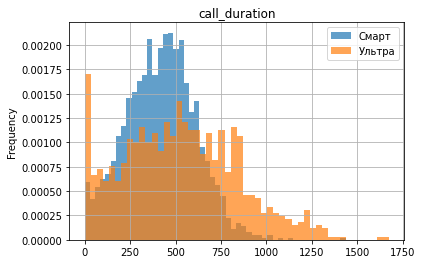

,var,std
tariff,,
smart,36219.32,190.31
ultra,100873.63,317.61


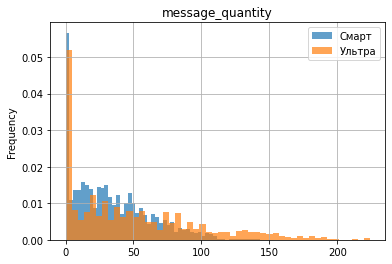

,var,std
tariff,,
smart,796.81,28.23
ultra,2285.27,47.80


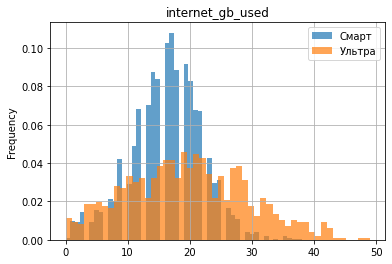

,var,std
tariff,,
smart,33.03,5.75
ultra,97.09,9.85


In [23]:
for column in ['call_duration', 'message_quantity', 'internet_gb_used']:
    data_smart[column].plot(kind='hist', bins=50, grid=True, density=True, label="Смарт", alpha=0.7)
    data_ultra[column].plot(kind='hist', bins=50, grid=True, density=True, label="Ультра", alpha=0.7)
    plt.title(column)
    plt.legend(loc="upper right")
    plt.show()
    # расчет дисперсии и стандартного отклонения
    display(data.groupby('tariff')[column].agg(['var','std']).round(2))

Дисперсия характеризует разброс случайной величины вокруг ее математического ожидания. Дисперсия и стандартное отклонение всех значений больше в тарифе Ультра.

### Вывод

Были свормированы две таблицы по тарифам Смарт и Ультра.

В среднем пользователи тарифа Смарт осуществляют звонки длительностью 422 минуты, отправляют 28 сообщения и искользуют 17гб интернета в месяц. Пользователи тарифа Ультра в среднем осуществляют звонки длительностью 518 минуты, отправляют 38 сообщения и искользуют 19гб интернета в месяц. То есть средние значения по тарифам не очень сильно отличаются. 

Для характеристики разброса значений были посчитаны дисперсия и среднее отклонение для всех значений по двум тарифам. Также посмроены гистограммы с наложением на друг друга для наглядности. 

Распределения тарифа Смарт больше похожи на нормальные, в то время как у тарифа Ультра больший разброс, скачки графика, как следсвие и дисперсия, и стандартное отклонение больше.

## Проверка гипотез

### Гипотеза средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Проверим гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Для проверки импользуем  t-тест для следующих статистических гипотез:
* H0: средняя выручка пользователей тарифов «Ультра» и «Смарт» равна
* H1: средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна

Используем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам `scipy.stats.ttest_ind` с параметрами выручки `data_smart['income']` и `data_ultra['income']`.

In [24]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(data_smart['income'], data_ultra['income'], equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


Нулевую гипотезу в ходе t-теста мы отвергаем, вероятность почти равна 0, следовательно H1 мы отвергнуть не можем.

Для наглядности построим графики распределения выручки по каждому тарифу.

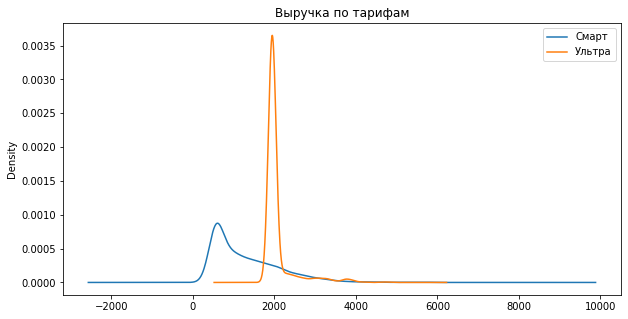

In [25]:
data_smart['income'].plot(kind='kde', figsize=(10,5), label="Смарт")
data_ultra['income'].plot(kind='kde', figsize=(10,5), label="Ультра")
plt.title('Выручка по тарифам')
plt.legend(loc="upper right")
plt.show()

### Гипотеза выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Проверим гипотезу о том, что выручка пользователей Москвы и других регионов различаются.

Для проверки импользуем  t-тест для следующих статистических гипотез:
* H0: средняя выручка пользователей Москвы и других регионов равна
* H1: средняя выручка пользователей Москвы и других регионов не равна

Для исследования выделим данные в две таблицы `data_msk` и `data_not_msk`, исходя из значения столбца `city`. Используем для этих таблиц метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам `scipy.stats.ttest_ind`.

In [26]:
data_msk = data.query('city == "Москва"')
data_not_msk = data.query('city != "Москва"')

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(data_msk['income'], data_not_msk['income'], equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергуть не получилось, то есть вероятность того, что выручка в Москве и других регионах равна, не достаточно мала.

Для наглядности построим графики распределения выручки по Москве и остальным регионам.

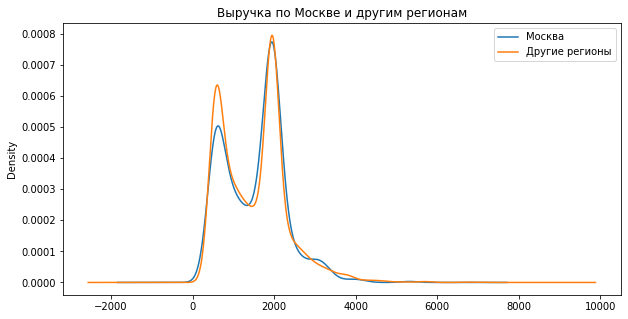

In [27]:
data_msk['income'].plot(kind='kde', figsize=(10,5), label="Москва")
data_not_msk['income'].plot(kind='kde', figsize=(10,5), label="Другие регионы")
plt.title('Выручка по Москве и другим регионам')
plt.legend(loc="upper right")
plt.show()

Видна схожесть графиков распределения по Москве и другим регионам.

### Вывод

Были проведены t-тесты и построены графики распреления для двух гипотез.

Гипотезу о неравенстве средней выручки пользователей тарифов «Ультра» и «Смарт» не удалось отвергуть, она верноятна.

Гепотезу о том, что выручка пользователей из Москвы отличается от выручки пользователей из других регионов, отвергли в ходе исследования.

## Общий вывод

В ходе проекта были осуществлены следующие этапы:
* Изучение данных файла;
* Предобратотка данных (включающая в себя обработку пропусков, расчеты параметров по месяцам, объединение данных в одну таблицу, изменение типов данных и проверка на дубликаты);
* Анализ поведения пользователей в зависимости от тарифа (по минутам звонков, количесву сообщений и расходу интернет-тарфика);
* Проверка гипотез

В ходе анализа данных выявили, что расходы минут, сообщений и интернета пользователей разных тарифов имеют близкое среднее. При этом у тарифа Смарт распределение более походит на нормальное, а у тарифа Ультра есть скачки и разбросы.

В результате проверки гипотезу о неравенстве выручки в зависимости от тарифа не удаось отвергнуть, гипотезу о неравенсве выручки в замисимоти от Москвы и др. регионов отвергли.

Выручка по тарифу Ультра почти всегда 1950р - это стоимость пакета, очень небольшое количество пользователей за нее выходят. Пользователи тарифа Смарт тоже чаще платят по стоимости пакета, но очень много большей выручки - переплат. Иногда расход пользователей этого тарифа превышает и месячную плату за тариф Ультра.

Сравним доходы комапнии от тарифов Смарт и Ультра с помощью метода `describe()`. Объеденим результат в одну таблицу для наглядности.

In [28]:
smart = data_smart[['income']].describe()
ultra = data_ultra[['income']].describe()
display(smart.join(ultra, how='left', lsuffix='_smart', rsuffix='_ultra'))

,income_smart,income_ultra
count,2229.000000,985.000000
mean,1289.973531,2070.152284
std,818.404367,376.187114
min,550.000000,1950.000000
25%,550.000000,1950.000000
50%,1023.000000,1950.000000
75%,1750.000000,1950.000000
max,6770.000000,4800.000000


Тариф Ультра приносит больше денег компании на всех значениях (и минимальном, и среднем, и максимальном). То есть коммерчески тариф Ульра более выгодный для компании. Следовательно рекламу стоит направить именно на данный тариф, тем более что клиентов, использующих тариф Смарт в 2 раза больше.